# Dependency

In [ ]:
!pip install git+https://github.com/davidbau/baukit
!pip install accelerate
!pip install einops

In [2]:
import os
import json
import pickle
import random
import warnings
import gc

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from einops import rearrange
from IPython.display import display, HTML
from scipy.stats import spearmanr
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from baukit import Trace, TraceDict
from custom_llama import llama # modified code to access attention head outputs

warnings.filterwarnings("ignore")

In [3]:
HUGGINGFACE_TOKEN = os.environ.get("HF_ACCESS_TOKEN")

In [4]:
os.environ["HTTP_PROXY"] = "http://127.0.0.1:10808"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:10808"

In [ ]:
def load_tokenizer_and_model(model_name, device='cpu', hf_token=None):
    """
    Loads a tokenizer and model for causal LM generation.
    """
    tokenizer = AutoTokenizer.from_pretrained(
        model_name, cache_dir='./model', use_auth_token=hf_token
    )
    model = llama.LlamaForCausalLM.from_pretrained(
        model_name,
        cache_dir='./model',
        torch_dtype=torch.float16 if device.startswith('cuda') else torch.float32,
        low_cpu_mem_usage=True,
        use_auth_token=hf_token
    ).to(device).eval()
    return tokenizer, model


def extract_attention_head_activations(model, prompts):
    """
    Extracts prefill attention head activations for a list of prompts.
    """
    HEADS = [f"model.layers.{i}.self_attn.head_out" for i in range(model.config.num_hidden_layers)]
    head_wise_hidden_states_list = []

    for prompt in tqdm(prompts, total=len(prompts)):
        with torch.no_grad():
            with TraceDict(model, HEADS) as ret:
                output = model(prompt.to('cuda'), output_hidden_states=True, output_attentions=True)
                head_wise_hidden_states = [ret[head].output.squeeze().detach().cpu() for head in HEADS]
                head_wise_hidden_states = torch.stack(head_wise_hidden_states, dim=0).squeeze().numpy()
                head_wise_hidden_states_list.append(head_wise_hidden_states[:, :, :])

    features = [
        rearrange([states[:, -1, :]], 'b l (h d) -> b l h d', h=model.config.num_attention_heads)
        for states in head_wise_hidden_states_list
    ]
    return np.stack(features, axis=0)


def extract_and_save_features(model, tokenizer, model_name, df_prompts, output_dir="results_replication", output_suffix="anes_features"):
    """
    Given a DataFrame with columns ['prompt', 'label'], extract attention features and save to pickle.
    """
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # Tokenize all prompts
    encoded = [tokenizer(p, return_tensors='pt')['input_ids'].to(device) for p in df_prompts['prompt']]
    labels = df_prompts['label'].values

    # Extract features
    features = extract_attention_head_activations(model, encoded)

    # Save
    out_path = f"{output_dir}/{model_name.replace('/', '_')}_{output_suffix}.pkl"
    with open(out_path, 'wb') as f:
        pickle.dump((features, labels), f)
    print(f"Saved features to {out_path}")


def clean_up(device=None):
    """
    Clean up the model and GPU memory.
    """
    gc.collect()
    if device:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

In [ ]:
from einops import rearrange
from tqdm import tqdm
import numpy as np
import torch


def extract_head_out_per_token(model, tokenizer, prompts, max_new_tokens=32):
    """
    Returns:
        features: (N, L, T, H, D)
            N = number of prompts
            L = number of layers
            T = number of generated tokens
            H = number of heads
            D = head dim
    """
    device = next(model.parameters()).device
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    hidden_size = model.config.hidden_size
    head_dim = hidden_size // num_heads

    HEADS = [f"model.layers.{i}.self_attn.head_out" for i in range(num_layers)]

    all_features = []

    for prompt in tqdm(prompts):
        input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(device)

        # We store (num_layers, num_steps, hidden_dim)
        token_outputs_by_layer = [[] for _ in range(num_layers)]

        # Define hook
        def make_hook(layer_idx):
            def hook_fn(module, inp, out):
                token_outputs_by_layer[layer_idx].append(out.squeeze(0).detach().cpu())
            return hook_fn

        # Register hooks
        hooks = []
        for i, name in enumerate(HEADS):
            module = dict(model.named_modules())[name]
            hooks.append(module.register_forward_hook(make_hook(i)))

        # Run generation
        _ = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            return_dict_in_generate=True,
            output_attentions=False
        )

        # Remove hooks
        for h in hooks:
            h.remove()

        # Stack and reshape
        layerwise_outputs = []
        for layer_outputs in token_outputs_by_layer:
            # layer_outputs: List[T] of (hidden_size,)
            stacked = torch.stack(layer_outputs, dim=0)  # → (T, hidden_size)
            reshaped = stacked.view(stacked.size(0), num_heads, head_dim)  # → (T, H, D)
            layerwise_outputs.append(reshaped)

        layerwise_outputs = torch.stack(layerwise_outputs, dim=0)  # → (L, T, H, D)
        layerwise_outputs = rearrange(layerwise_outputs, 'l t h d -> t l h d') # → (T, L, H, D)
        all_features.append(layerwise_outputs.numpy())

    return np.stack(all_features, axis=0)  # → (N, T, L,  H, D)

# Preprocessing Data

In [7]:
df = pd.read_csv('./data_replication/HS116_members.csv')
df = df.loc[pd.notnull(df.nominate_dim1)].reset_index(drop=True)
df['first_middle_name'] = df['bioname'].apply(lambda x: x.split(', ')[1])
df['first_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[0] + ' ' if ' ' in x else x + ' ')
df['middle_name'] = df['first_middle_name'].apply(lambda x: x.split(' ')[1][0] + '. ' if ' ' in x else '')
df['last_name'] = df['bioname'].apply(lambda x: x.split(', ')[0].lower().capitalize().strip())
df['fullname'] = df['first_name'] + df['middle_name'] + df['last_name']

In [8]:
adfontesmedia = pd.read_csv('./data_replication/adfontesmedia.csv')

# Probing Partisan Slant

## Prompting

1. Could there be one head for each policy domain?
2. Why is there only one head (k=1) that generates the best divergence between the liberal/conservative perspectives?
3. Why is the results averaged when adding heads? Is it because of the policy domains?
4. When I ask about what socks liberal/conservatives would buy for Christmas, I get the same results with the DW NOMINATE probes. So the probes are only sensitive to the liberal/conservative divergence, but not the actual questions or domains asked? Which kind of makes sense, since the probes are not trained on any specific domain, but rather on the general democrat/republican divergence found in the DW NOMINATE data.
5. How do I quantify the contribution of each policy domain to the liberal/conservative divergence? Is there a way to combine the policy probes to get the results of the DW NOMINATE probes?
6. Maybe I can retrain the probes without any data?
7. What about using MSE/KL Divergence for classification when the dimension is discrete? Instead of using regression when target is continuous?

## Politicians

In [ ]:
## Generate politician simulation prompts

for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    tokenizer = llama.LlamaTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
    
    # Generate prompts for politician simulation
    statements = []
    for index, row in df.iterrows():
        statements.append(tokenizer(f'USER: Generate a statement by {row["fullname"]}, a politician in the United States.\nASSISTANT: In 2019, {row["fullname"]} said that', return_tensors="pt")['input_ids'])
    pickle.dump(statements, open(f'./results_replication/{model_name.replace("/", "_")}_politicians.pkl', 'wb'))
    
    # Generate prompts for news media simulation
    statements_news = []
    for index, row in adfontesmedia.iterrows():
        statements_news.append(tokenizer(f'USER: Generate a statement from a news source in the United States.\nASSISTANT: {row["moniker_name"]} reported that', return_tensors="pt")['input_ids'])
    pickle.dump(statements_news, open(f'./results_replication/{model_name.replace("/", "_")}_news.pkl', 'wb'))

### Extracting Activations

In [10]:
# for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']: #
for model_name in ['meta-llama/Llama-2-7b-chat-hf']:
    model = llama.LlamaForCausalLM.from_pretrained(model_name, cache_dir='./model', low_cpu_mem_usage=True, torch_dtype=torch.float16, token=HUGGINGFACE_TOKEN).to('cuda:0')
    # Extract activations for politicians
    statements = pickle.load(open(f'./results_replication/{model_name.replace("/", "_")}_politicians.pkl', 'rb'))
    labels = np.array(df['nominate_dim1'].astype(float))
    features = extract_attention_head_activations(model, statements)
    pickle.dump((features, labels), open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'wb'))

    # Extract activations for news media
    statements_news = pickle.load(open(f'./results_replication/{model_name.replace("/", "_")}_news.pkl', 'rb'))
    labels = np.array(adfontesmedia['bias_mean'].astype(float))
    features = extract_attention_head_activations(model, statements_news)
    pickle.dump((features, labels), open(f"./results_replication/{model_name.replace('/','_')}_news_features.pkl", 'wb'))

    del model
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

Plink failed to import tkinter.


2025-05-14 02:21:51.193398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747160511.214228  460639 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747160511.220648  460639 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 02:21:51.242269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[2025-05-14 02:21:53,040] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


No ROCm runtime is found, using ROCM_HOME='/opt/rocm'
LlamaForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

## No dataset

### Prepare prompts

In [6]:
import itertools
import pandas as pd

# 1–7 ANES scale labels
labels = list(range(1, 8))

# Policy domain mapping: key → full question text
policies = {
    "renewable_energy": "expanding federal funding for renewable energy in the U.S.",
    "build_back_better": "the Build Back Better Act’s proposed child tax credits",
    "vaccine_mandates": "federal COVID-19 vaccine mandates in the United States",
    "minimum_wage": "raising the U.S. federal minimum wage to $15/hour",
    "infrastructure_bill": "the proposed 2021 U.S. infrastructure bill",
    "student_loan": "proposals for U.S. federal student loan forgiveness",
    "abortion": "abortion policy in the United States (2021)",
    "border_wall": "building a wall on the U.S.–Mexico border",
    "transgender_bathroom": "allowing transgender individuals to use public bathrooms matching their gender identity in U.S. facilities",
    "ukraine_military_aid": "the U.S. providing weapons to help Ukraine defend against Russia",
    "israel_military_aid": "the U.S. giving military assistance to Israel",
    "gaza_humanitarian_aid": "the U.S. providing humanitarian aid to Palestinians in the Gaza Strip",
    "free_form": "the current U.S. political landscape in 2021"  # free-form policy
}

# Prompt templates (each takes 'scale' and 'policy_text')
def tpl_zero_shot(scale, policy_text):
    return (
        f"You are a self-identified {scale} "
        f"(1 = extremely liberal, 7 = extremely conservative) on the ANES 7-point ideology scale in the U.S. "
        f"In 2021, what is your stance on {policy_text}? "
    )


def tpl_scale_defined(scale, policy_text):
    return (
        f"In the United States in 2021, on a scale from 1 to 7 where 1 means \"extremely liberal\" and 7 means \"extremely conservative\", "
        f"you identify as {scale}. "
        f"What do you think about {policy_text}, and why?"
    )


def tpl_few_shot(scale, policy_text):
    return (
        "Example (U.S. voter):\n"
        "  Voter (Scale 1 – extremely liberal) in 2021 on healthcare: "
        "\"I support a Medicare-for-All system because it ensures universal access regardless of income.\"\n\n"
        f"Now you:\n"
        f"  You are a U.S. voter (Scale {scale}) in 2021. "
        f"What is your view on {policy_text}?"
    )


def tpl_with_context(scale, policy_text):
    return (
        "In the American National Election Studies (ANES), U.S. respondents rate themselves on a 7-point ideology scale.\n"
        f"You place yourself at {scale}. "
        f"In 2021, what is your perspective on {policy_text}?"
    )


def tpl_chain_of_thought(scale, policy_text):
    return (
        f"You are a self-identified {scale} on the ANES scale in the U.S.\n"
        "First, list three values that guide your political views (e.g., equity, national security, personal freedom).\n"
        f"Then, based on those values, state your position on {policy_text}."
    )

# Collect rows
templates = [
    tpl_zero_shot,
    tpl_scale_defined,
    tpl_few_shot,
    tpl_with_context,
    tpl_chain_of_thought,
]

rows = []
for scale, (policy_key, policy_text) in itertools.product(labels, policies.items()):
    for tpl in templates:
        core = tpl(scale, policy_text)
        policy_label = policy_key

        # Wrap with USER/ASSISTANT template
        wrapped = (
            f"USER: {core}\n"
            f"ASSISTANT: In 2021, a U.S. voter identifying as {scale} said that"
        )

        rows.append({
            "prompt": wrapped,
            "policy": policy_label,
            "label": scale
        })

# Create DataFrame and save
df_prompts = pd.DataFrame(rows, columns=["prompt", "policy", "label"])
df_prompts.to_csv("data_replication/anes_prompts.csv", index=False)
print(f"Generated {len(df_prompts)} prompts.")


Generated 455 prompts.


### Extract features

In [ ]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

tokenizer, model = load_tokenizer_and_model(model_name, device=device, hf_token=HUGGINGFACE_TOKEN)
df_prompts = pd.read_csv('data_replication/anes_prompts.csv')

# Tokenize all prompts
extract_and_save_features(model, tokenizer, model_name, df_prompts, output_dir="results_replication", output_suffix="anes_features")

In [ ]:
# Clean up
del model
clean_up(device=device)

In [13]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

tokenizer, model = load_tokenizer_and_model(model_name, device=device, hf_token=HUGGINGFACE_TOKEN)

features, labels = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_anes_features.pkl", 'rb'))
performance = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
ridge_dict = {}
for i in tqdm(range(model.config.num_hidden_layers)):
    ridge_dict[i] = {}
    for j in range(model.config.num_attention_heads):
        kf = KFold(n_splits=2, shuffle=True, random_state=42)
        for train_indices, test_indices in kf.split(range(features.shape[0])):
            X_train = features[train_indices, 0, i, j, :]
            X_test = features[test_indices, 0, i, j, :]
            y_train = np.array(labels)[train_indices]
            y_test = np.array(labels)[test_indices]
            ridge_model = Ridge(alpha=1, fit_intercept=False)
            ridge_model.fit(X_train, y_train)
            ridge_dict[i][j] = ridge_model
            y_pred = ridge_model.predict(X_test)
            performance[i, j] += spearmanr(y_test, y_pred).statistic
performance /= 2
pickle.dump(performance, open(f"./results_replication/{model_name.replace('/','_')}_anes_performance.pkl", 'wb'))
pickle.dump(ridge_dict, open(f"./results_replication/{model_name.replace('/','_')}_anes_ridge.pkl", 'wb'))

# Print performance
# print("Performance (Spearman correlation):")
# def print_performance(performance, model_name):
#     for i in range(performance.shape[0]):
#         for j in range(performance.shape[1]):
#             print(f"Layer {i}, Head {j}: {performance[i, j]:.4f}")
#     print(f"Average performance: {np.mean(performance):.4f}")

# print_performance(performance, model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

## Probing tests

In [ ]:
# Prompt builder
def build_prompt(alignment, query):
    return (
        f"USER: Generate a statement from the {alignment} on the following question in the United States. "
        # f"{query.strip()}\n"
        f"Do you favor or oppose buying green socks for Christmas?\n"
        f"ASSISTANT: In 2021, the {alignment} believes that"
    )

In [ ]:
import torch
import pickle
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm
from einops import rearrange
from transformers import AutoTokenizer, AutoModelForCausalLM

model_names = [
    'meta-llama/Llama-2-7b-chat-hf',
    'mistralai/Mistral-7B-Instruct-v0.1',
    'lmsys/vicuna-7b-v1.5'
]

# Load domain-specific queries
df = pd.read_csv("data_replication/anes.csv")

# Loop over models
for model_name in model_names:
    print(f"\nProcessing model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
    model = llama.LlamaForCausalLM.from_pretrained(
        model_name,
        cache_dir='./model',
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
        token=HUGGINGFACE_TOKEN
    ).to('cuda:0')

    # Collect all prompts and labels across all domains
    prompts_data = []

    for _, row in df.iterrows():
        domain, question = row['domain'], row['query']
        for alignment, label in [('liberal', -1), ('conservative', 1)]:
            prompt = build_prompt(alignment, question)
            prompts_data.append((prompt, label))

    # Tokenize
    encoded_prompts = [tokenizer(p, return_tensors='pt')['input_ids'] for p, _ in prompts_data]
    labels = np.array([label for _, label in prompts_data])

    # Extract features
    features = extract_attention_head_activations(model, encoded_prompts)

    # Save once per model
    out_path = f"./results_replication/{model_name.replace('/', '_')}_voter_features.pkl"
    pickle.dump((features, labels), open(out_path, 'wb'))
    print(f"Saved to {out_path}")

    del model
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()



Processing model: meta-llama/Llama-2-7b-chat-hf


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 19.82it/s]


Saved to ./results_replication/meta-llama_Llama-2-7b-chat-hf_voter_features.pkl

Processing model: mistralai/Mistral-7B-Instruct-v0.1


You are using a model of type mistral to instantiate a model of type llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 19.88it/s]


Saved to ./results_replication/mistralai_Mistral-7B-Instruct-v0.1_voter_features.pkl

Processing model: lmsys/vicuna-7b-v1.5


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 20.38it/s]


Saved to ./results_replication/lmsys_vicuna-7b-v1.5_voter_features.pkl


meta-llama/Llama-2-7b-chat-hf 4 nan
[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1] [-0.21802253 -0.21802253 -0.21802253 -0.21802253 -0.21802253 -0.21802253
 -0.21802253 -0.21802253 -0.21802253 -0.21802253 -0.21802253 -0.21802253]


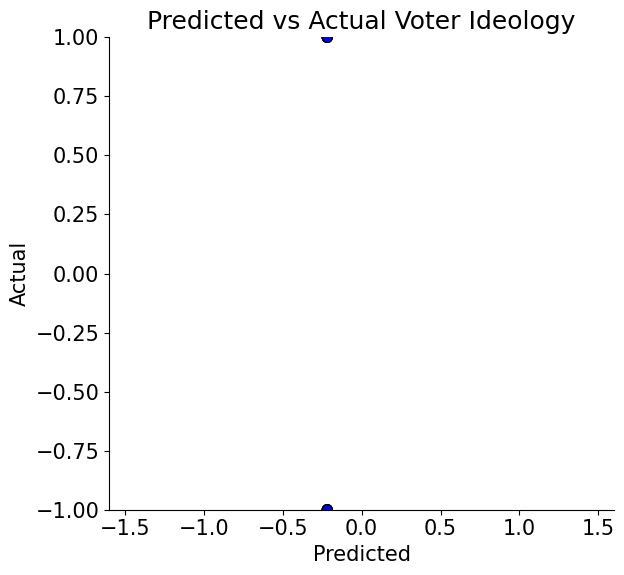

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

# Setup
cmap = mcolors.LinearSegmentedColormap.from_list("red_white_blue", ["blue", "white", "red"])
model_name = 'meta-llama/Llama-2-7b-chat-hf'
k = 4

# Load data
features_voters, labels_voters = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_voter_features.pkl", 'rb'))
features_politicians, labels_politicians = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'rb'))
performance = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_performance.pkl", 'rb'))

# Top-k (i, j) heads
top_indices = np.dstack(np.unravel_index(np.argsort(performance.ravel()), (32, 32)))[0][-k:, :]

# Ensemble prediction over voter samples
kf = KFold(n_splits=2, shuffle=True, random_state=42)
ensemble_pred = np.zeros(labels_voters.shape)

for train_indices, test_indices in kf.split(range(features_politicians.shape[0])):
    for i, j in top_indices:
        X_train = features_politicians[train_indices, 0, i, j, :]
        X_test = features_politicians[test_indices, 0, i, j, :]
        y_train = np.array(labels_politicians)[train_indices]
        y_test = np.array(labels_politicians)[test_indices]
        
        ridge_model = Ridge(alpha=1, fit_intercept=False)
        ridge_model.fit(X_train, y_train)
        
        y_pred = ridge_model.predict(features_voters[:, 0, i, j, :])
        ensemble_pred += y_pred

ensemble_pred = ensemble_pred / k / 2
print(model_name, k, spearmanr(labels_voters, ensemble_pred).statistic)
print(labels_voters, ensemble_pred)

# Plotting
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(6.5, 6))
plt.grid(False)
plt.title("Predicted vs Actual Voter Ideology")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.scatter(ensemble_pred, labels_voters, c=ensemble_pred, cmap=cmap, alpha=0.8, s=50, edgecolor='black')
plt.xlim(-1.6, 1.6)
plt.ylim(-1, 1)
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('llama2_voters.pdf')


In [69]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = 'meta-llama/Llama-2-7b-chat-hf'  # ← change this as needed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir='./model',
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    low_cpu_mem_usage=True,
    token=HUGGINGFACE_TOKEN
).to(device).eval()

# Load question data
df = pd.read_csv("data_replication/anes.csv")

# Generate and print answers
for _, row in df.iterrows():
    domain, query = row['domain'], row['query']
    print(f"\n🧭 Domain: {domain}")

    for alignment in ['liberal', 'conservative']:
        prompt = build_prompt(alignment, query)
        inputs = tokenizer(prompt, return_tensors='pt').to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=30,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        answer = decoded.replace(prompt, '').strip()
        print(f"  [{alignment.title()}] → {answer}")

del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


🧭 Domain: Abortion
  [Liberal] → abortion should be legal in most cases, with 62% of them supporting the statement "Abortion should be legal in most cases,
  [Conservative] → abortion should be illegal in most cases, with a scale rating of 5. However, it's important to note that opinions on this matter

🧭 Domain: Border Wall
  [Liberal] → building a wall on the U.S. border with Mexico was not a viable or effective solution to address the complex issues surrounding immigration. Many
  [Conservative] → building a wall on the U.S. border with Mexico was a necessary measure to secure the country's borders and prevent illegal immigration. However

🧭 Domain: Transgender Bathroom
  [Liberal] → transgender people should be allowed to use public bathrooms matching their gender identity. According to a survey conducted by the Pew Research Center, 7
  [Conservative] → allowing transgender people to use public bathrooms matching their gender identity was a controversial issue. While some conserva

## Probing

In [ ]:
for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    features, labels = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'rb'))
    performance = np.zeros((model.config.num_hidden_layers, model.config.num_attention_heads))
    ridge_dict = {}
    for i in tqdm(range(model.config.num_hidden_layers)):
        ridge_dict[i] = {}
        for j in range(model.config.num_attention_heads):
            kf = KFold(n_splits=2, shuffle=True, random_state=42)
            for train_indices, test_indices in kf.split(range(features.shape[0])):
                X_train = features[train_indices, 0, i, j, :]
                X_test = features[test_indices, 0, i, j, :]
                y_train = np.array(labels)[train_indices]
                y_test = np.array(labels)[test_indices]
                ridge_model = Ridge(alpha=1, fit_intercept=False)
                ridge_model.fit(X_train, y_train)
                ridge_dict[i][j] = ridge_model
                y_pred = ridge_model.predict(X_test)
                performance[i, j] += spearmanr(y_test, y_pred).statistic
    performance /= 2
    pickle.dump(performance, open(f"./results_replication/{model_name.replace('/','_')}_politician_performance.pkl", 'wb'))
    pickle.dump(ridge_dict, open(f"./results_replication/{model_name.replace('/','_')}_ridge.pkl", 'wb'))

# Intervention

In [ ]:
def lt_modulated_vector_add(head_output, layer_name):
    layer_index = layer_name[len('model.layers.'):]
    layer_index = int(layer_index[:layer_index.index('.')])
    head_output = rearrange(head_output.detach().cpu(), 'b s (h d) -> b s h d', h=model.config.num_attention_heads)
    for head_index in head_dict[layer_index]:
        head_output[:, -1, head_index, :] += alpha  * focal_ridge_dict[(layer_index, head_index)] * np.std(features[:, 0, layer_index, head_index, :], axis=0)
    head_output = rearrange(head_output, 'b s h d -> b s (h d)')
    return head_output.to('cuda')

for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    tokenizer = llama.LlamaTokenizer.from_pretrained(model_name, cache_dir='./model', token=HUGGINGFACE_TOKEN)
    model = llama.LlamaForCausalLM.from_pretrained(model_name, cache_dir='./model', low_cpu_mem_usage=True, torch_dtype=torch.float16, 
                                                   token=HUGGINGFACE_TOKEN).to('cuda:0')
    performance = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_performance.pkl", 'rb'))
    features, labels = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_politician_features.pkl", 'rb'))
    trained_ridge_dict = pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_ridge.pkl", 'rb'))
    topics = ['abortion', 'immigration', 'gun control', 'same-sex marriage', 'LGBTQ+ rights', 
              'climate change', 'trust in science', 'social media regulation', 'free speech']
    results = []
    for k in reversed([16, 32, 48, 64, 80, 96]):
        for alpha in tqdm(reversed([-30, -20, -10, 0, 10, 20, 30])): # Add -50, -40, 40, 50 for the coherence tests
            for topic in topics:
                print(k, alpha, topic)
                original_prompt = f"Write a statement about {topic}."
                top_indices = np.dstack(np.unravel_index(np.argsort(performance.ravel()), (32, 32)))[0][-k:, :][::-1]
                focal_ridge_dict = {}
                for i in top_indices:
                    ridge_model = trained_ridge_dict[i[0]][i[1]]
                    focal_ridge_dict[tuple(i)] = ridge_model.coef_
                head_dict = {}
                for i in top_indices:
                    if i[0] not in head_dict:
                        head_dict[i[0]] = [i[1]]
                    else:
                        head_dict[i[0]].append(i[1])
                with TraceDict(model, [f'model.layers.{i}.self_attn.head_out' for i in sorted(list(set(top_indices[:,0])))], edit_output=lt_modulated_vector_add) as ret: 
                    input_ids = tokenizer(f"USER: {original_prompt}\nASSISTANT: Regarding {topic}, I believe that ", return_tensors="pt")['input_ids']
                    model_gen_tokens = model.generate(input_ids.to('cuda')[0][:-1].unsqueeze(0), max_length=200)
                model_gen_str = tokenizer.decode(model_gen_tokens[0], skip_special_tokens=True)
                model_gen_str = model_gen_str.strip()
                results.append([k, alpha, topic, model_gen_str])
    pickle.dump(results, open(f"./results_replication/{model_name.replace('/','_')}_intervention_results.pkl", 'wb'))

In [ ]:
results = []
for model_name in ['meta-llama/Llama-2-7b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.1', 'lmsys/vicuna-7b-v1.5']:
    results += pickle.load(open(f"./results_replication/{model_name.replace('/','_')}_intervention_results.pkl", 'rb'))

pd.DataFrame(results).to_parquet('intervention_raw.parquet')